# Семинар 9
# Методы 0 порядка. Генетический алгоритм

**Вопрос:** Опишите возможности оракула. Что принимает оракул на вход, а что может дать на выход?

Мы будем рассматривать следующую задачу максимизации: $f: \mathbb{R}\rightarrow \mathbb{R}$:
$$ f(x) \rightarrow \max_{x \in {\mathbb{R}}} $$

со следующей "плохой" целевой функцией $f(x)$:

In [ ]:
import pylab
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

from matplotlib import animation
from IPython.display import HTML

In [ ]:
#@title Сигма -- уровень шума оракула
sigma = 0 #@param {type:"number"}
def f(x):
    return np.where((x - np.floor(x)) * np.abs(x + 5) < 0.2 * (np.abs(x) < 5), 
                    0.5 * np.floor(x),
           0.4 * np.exp(-2 * (x - 6)**2) + \
           2 * np.exp(-5 * (x + 4)**2) + \
           3 * np.exp(-0.5 * (x - 3)**4) + \
           0.5 * np.exp(- (x+7)**2) + \
           0.1 * np.cos(x * 30) + \
           0.01 * np.abs(x - 7) * np.sin(x**3 / 13) - \
           np.tanh(x**2) -
           0.1 * np.abs(x))

def J(x, sigma = sigma):
    return f(x) + sigma * np.random.normal(size=x.shape)

In [ ]:
def draw_F(size=(14,4)):
    figure(num=None, figsize=size, dpi=80, facecolor='w', edgecolor='k')
    font = {'size'   : 12}
    matplotlib.rc('font', **font)

    x = np.linspace(-10, 10, 1000)
    plt.plot(x, f(x), label="ground truth", alpha=0.6)
    
    pylab.xlabel("argument, $x$")
    pylab.ylabel("value, $f(x)$")
    plt.xlim(-10, 10)
    plt.ylim(-2.7, 2.1)

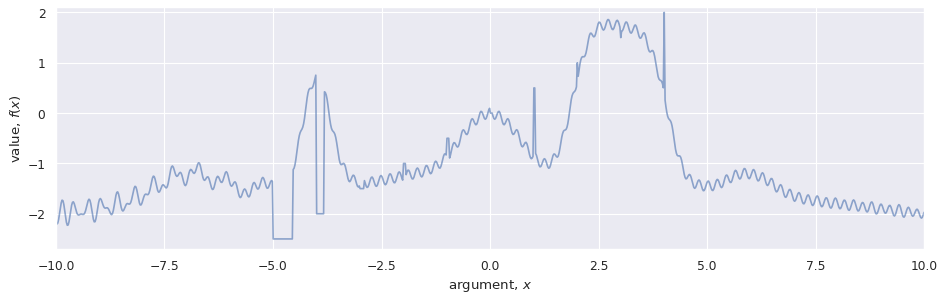

In [ ]:
draw_F()

## Случайный поиск (Random search)

In [ ]:
class RandomSearch():
    def __init__(self, size = 100):
        self.p = np.random.uniform(-10, 10, size)
        self.j = J(self.p)
        self.best = self.p[np.argmax(self.j)]
        self.best_j = self.j[np.argmax(self.j)]

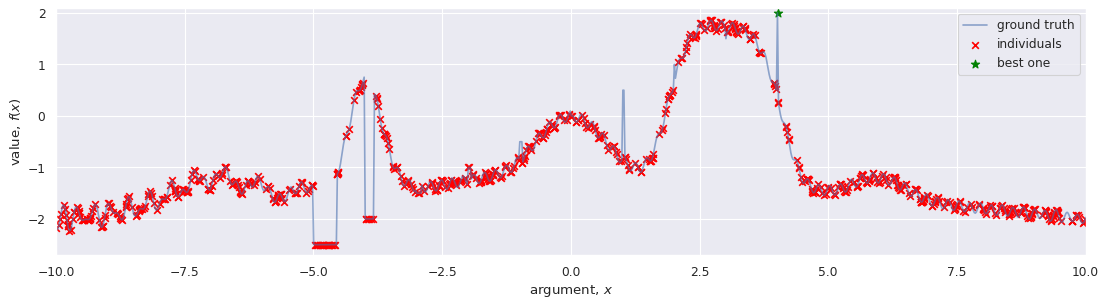

In [ ]:
#@title Число случайных точек { run: "auto" }
SIZE = 762 #@param {type:"slider", min:1, max:1000, step:1}
np.random.seed(111)

rs = RandomSearch(size=SIZE)

draw_F()
plt.scatter(rs.p[rs.j < rs.best_j], rs.j[rs.j < rs.best_j], marker="x", color="red", label="individuals")
plt.scatter(rs.best, rs.best_j, marker="*", color="green", label="best one", s=60)
plt.legend()
plt.tight_layout()
plt.savefig("randomsearch.png", transparent=True)

### Модификация случайного поиска:

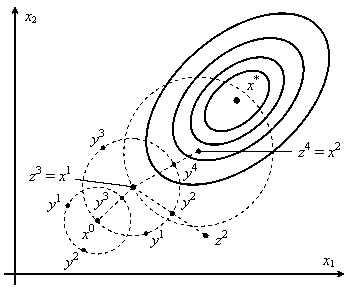

## Имитация отжига (Simulated annealing)

Описание алгоритма: [см. Wikipedia](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0)

In [ ]:
class Annealing():
    def __init__(self):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self.temp = 1
        
    def start_step(self):
        self.candidate = self.p + 0.9 * np.random.normal()
        self.candidate_j = J(self.candidate)
        
        self.proba = min(1, np.exp((self.candidate_j - self.j) * self.temp))
        self.accepted = np.random.uniform(0, 1) < self.proba
        
    def finish_step(self):
        if self.accepted:
            self.p = self.candidate
            self.j = self.candidate_j
        self.temp += 1

### Кадровая иллюстрация

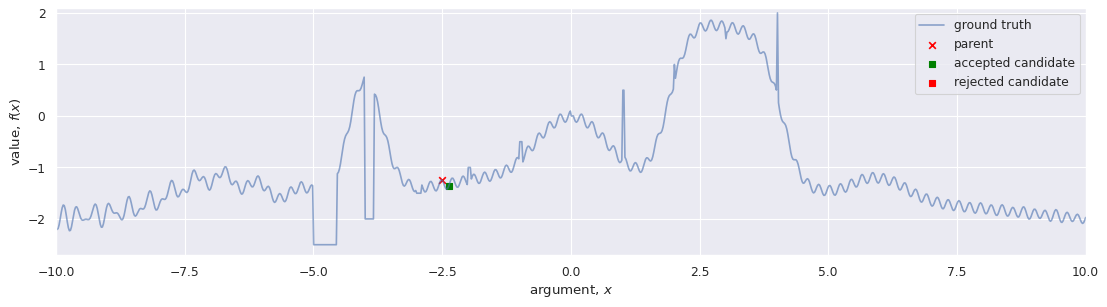

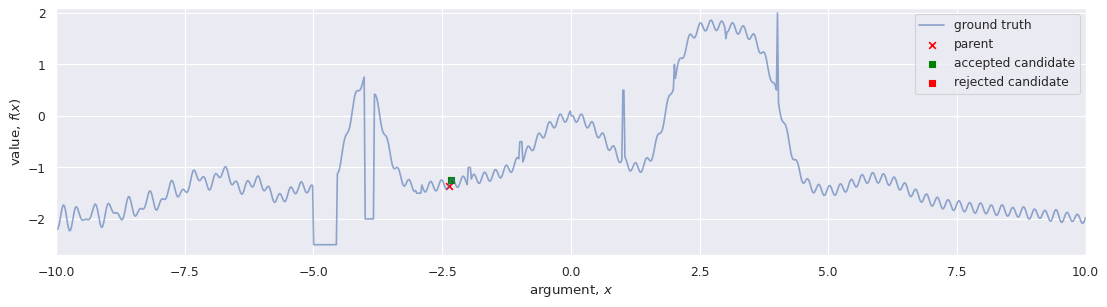

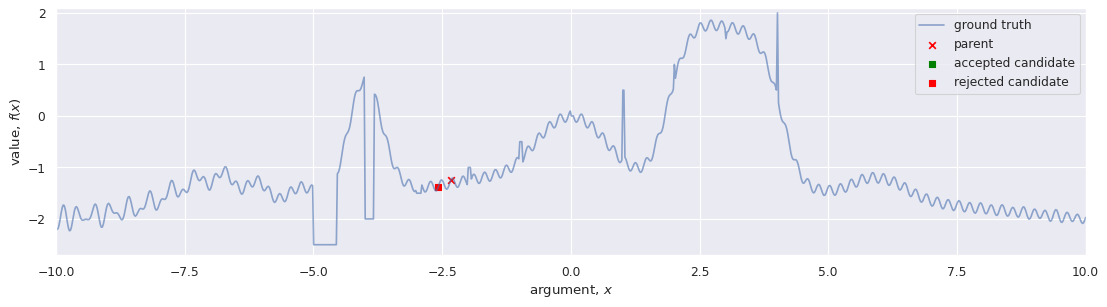

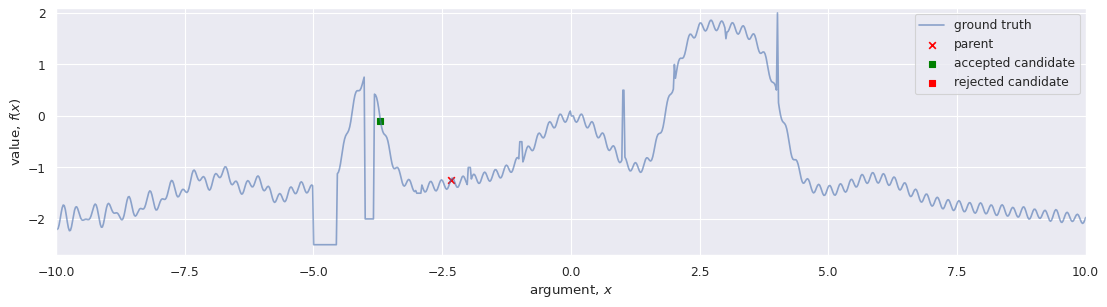

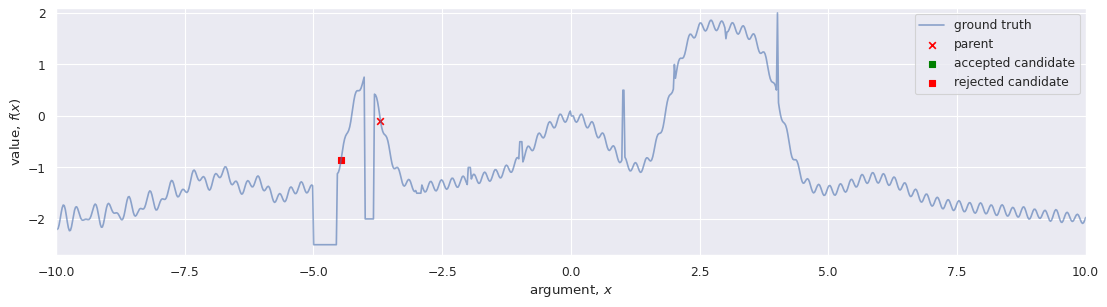

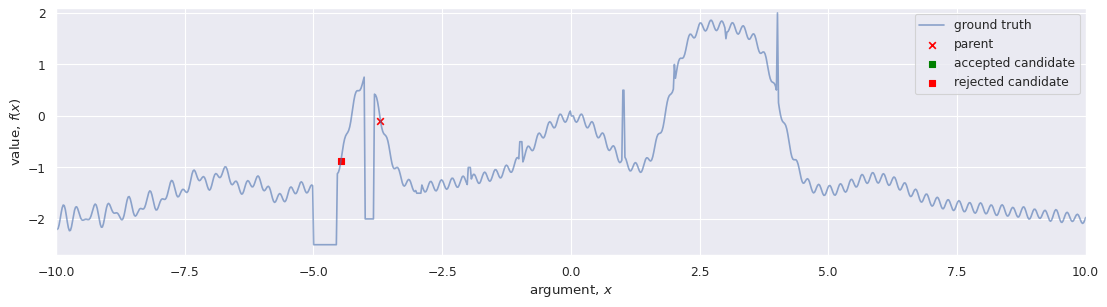

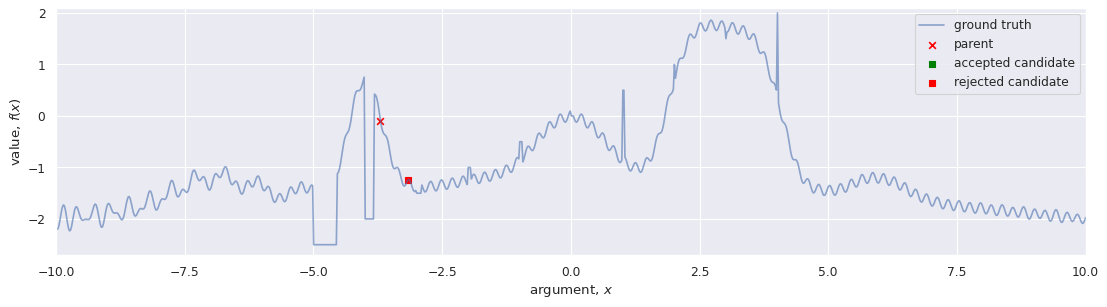

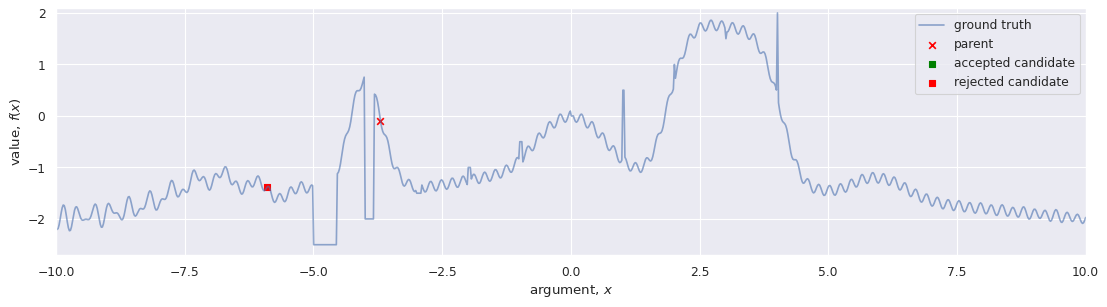

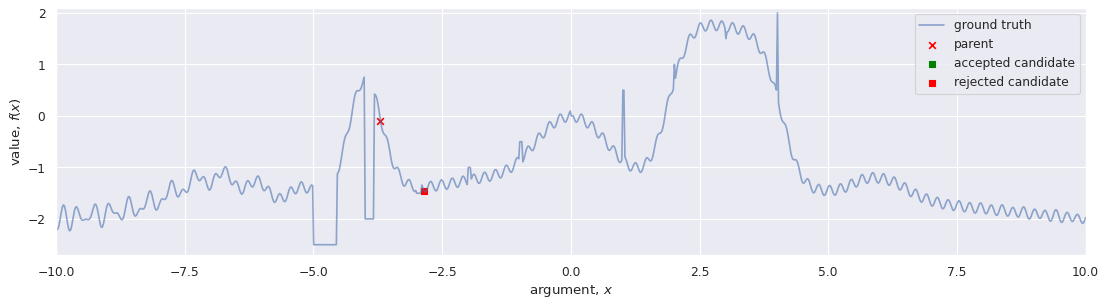

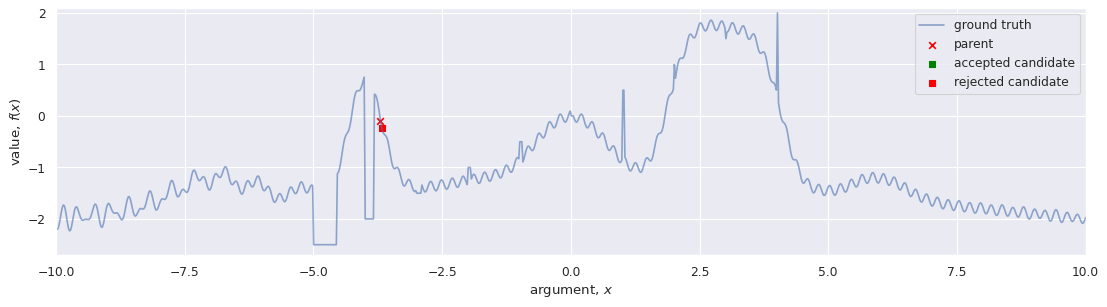

In [ ]:
np.random.seed(112)
N_iterations = 10

sa = Annealing()

for k in range(N_iterations):
    sa.start_step()
    draw_F()
    plt.scatter(sa.p, sa.j, marker="x", color="red", label="parent")

    if sa.accepted:
      plt.scatter(sa.candidate, sa.candidate_j, marker="s", color="green", label="accepted candidate")
      plt.scatter([], [], marker="s", color="red", label="rejected candidate")
    else:
      plt.scatter([], [], marker="s", color="green", label="accepted candidate")
      plt.scatter(sa.candidate, sa.candidate_j, marker="s", color="red", label="rejected candidate")
      
      

    sa.finish_step()
    plt.legend()
    plt.tight_layout()

### Видео иллюстрация

In [ ]:
np.random.seed(112)
N_iterations = 50

sa = Annealing()
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
parent         = plt.scatter([], [], marker="x", color="red", label="parent")
rej_candidates  = plt.scatter([], [], marker="s", color="red", label="rejected candidate")
acc_candidates  = plt.scatter([], [], marker="s", color="green", label="accepted candidate")

# animation function. This is called sequentially
def drawframe(n):
    sa.start_step()
    parent.set_offsets(np.column_stack((sa.p, sa.j)))

    if sa.accepted:
        acc_candidates.set_offsets(np.column_stack((sa.candidate, sa.candidate_j)))
        rej_candidates.set_offsets([None, None])
    else:
        acc_candidates.set_offsets([None, None])
        rej_candidates.set_offsets(np.column_stack((sa.candidate, sa.candidate_j)))

    sa.finish_step()
    txt_title.set_text(f"Simulated Annealing. {n} iteration.")
   
    return parent, acc_candidates, rej_candidates


# blit=True re-draws only the parts that have changed.
plt.legend()
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

## Hill Climbing

In [ ]:
class HillClimbing():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        
    def start_step(self):
        self.candidate = self.p + 0.5 * np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.p = self.candidate[np.argmax(self.candidate_j)]
        self.j = np.max(self.candidate_j)

In [ ]:
np.random.seed(133)
N_iterations = 50
N_candidates = 30

hc = HillClimbing(N_candidates)
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
parent      = plt.scatter([], [], marker="s", color="green", label="parent")
candidates  = plt.scatter([], [], marker="x", color="red", label="candidates")


# animation function. This is called sequentially
def drawframe(n):
    hc.start_step()
    parent.set_offsets(np.column_stack((hc.p, hc.j)))
    candidates.set_offsets(np.column_stack((hc.candidate, hc.candidate_j)))
    hc.finish_step()
    txt_title.set_text(f"Hill climbing. {n} iteration.")
   
    return parent, candidates


# blit=True re-draws only the parts that have changed.
plt.legend()
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

Задача коммивояжёра [см. Wikipedia](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BA%D0%BE%D0%BC%D0%BC%D0%B8%D0%B2%D0%BE%D1%8F%D0%B6%D1%91%D1%80%D0%B0)


## Эволюционная стратегия с M потоками (parents) и N выборками (candidates) на поток

In [ ]:
#@title Выбрать число потоков M и число выборок N { run: "auto" }
M = 10 #@param {type:"slider", min:1, max:10, step:1}
N = 10 #@param {type:"slider", min:1, max:10, step:1}

class MS_ES():
    def __init__(self, threads=M, samples_per_thread=N):
        self.p = np.random.uniform(-10, 10, size=(threads,))
        self.j = J(self.p)
        self.threads = threads
        self.samples_per_thread = samples_per_thread
        
    def start_step(self):
        self.candidate = (self.p + 0.5 * np.random.normal(size=(self.samples_per_thread, self.threads))).flatten()
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.thr = np.sort(self.candidate_j)[-self.threads]
        self.p = self.candidate[self.candidate_j >= self.thr]
        self.j = self.candidate_j[self.candidate_j >= self.thr]
        assert self.p.shape == (self.threads,)

In [ ]:
np.random.seed(144)
N_iterations = 50

es = MS_ES(M,N)
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
parents     = plt.scatter([], [], marker="s", color="green", label="parents")
candidates  = plt.scatter([], [], marker="x", color="red", label="candidates")


# animation function. This is called sequentially
def drawframe(n):
    es.start_step()
    parents.set_offsets(np.column_stack((es.p, es.j)))
    candidates.set_offsets(np.column_stack((es.candidate, es.candidate_j)))
    es.finish_step()
    txt_title.set_text(f"Evolutionary strategy with {M} threads and {N} samples per thread. {n} iteration.")
   
    return parents, candidates


# blit=True re-draws only the parts that have changed.
plt.legend()
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

## Эвалюционная стратегия с видами

In [ ]:
import numpy as np
from numpy.random import shuffle, choice

class Elitism():
    def __init__(self):
        self.p = np.random.uniform(-10, 10, size=(4,))
        self.j = J(self.p)
        self.reproduce = [5,5,5,5]
        
    def start_step(self):
        self.candidate = np.concatenate([self.p[i] + 0.9 * np.random.normal(size=(self.reproduce[i])) for i in range(len(self.p))])
        self.candidate_j = J(self.candidate)
        
    def split(self):
        indexes = np.arange(20)
        shuffle(indexes)
        self.species = []
        
        for i in indexes:
            c = self.candidate[i]
            
            shuffle(self.species)
            for s in self.species:
                representative = self.candidate[choice(list(s))]
                if np.abs(representative - c) < 1:
                    s.add(i)
                    break
            else:
                self.species.append({i})
                
        self.species_j = []
        for s in self.species:
            self.species_j.append(np.array([self.candidate_j[i] for i in s]).mean())
        
        p = np.exp(self.species_j)
        p /= p.sum()
        self.reproduce = np.bincount(choice(np.arange(len(self.species)), p=p, size=20), minlength=len(self.species))
        
    def finish_step(self):
        self.p = []
        self.j = []
        for s in self.species:
            s = list(s)
            best = np.argmax([self.candidate_j[i] for i in s])
            self.p.append(self.candidate[s[best]])
            self.j.append(self.candidate_j[s[best]])

In [ ]:
np.random.seed(155)

el = Elitism()
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
parents = plt.scatter([], [], marker="s", color="green", label="parents", s=70)
colors = ["lightsalmon", "slateblue", "crimson", "black", "teal", "goldenrod", 
          "magenta", "brown"]
candidates_list = [plt.scatter([], [], marker="x", color=color, s=70, label=f"{color}") for color in colors]



# animation function. This is called sequentially
def drawframe(n):
    el.start_step()
    parents.set_offsets(np.column_stack((el.p, el.j)))

    el.split()

    for i in range(len(colors)):
        candidates_list[i].set_offsets([None, None])
        candidates_list[i].set_label(None)

    
    for k in range(len(el.species)):
        color = colors[k]
        candidate = [el.candidate[i] for i in el.species[k]]
        candidate_j = [el.candidate_j[i] for i in el.species[k]]
        candidates_list[k].set_offsets(np.column_stack((candidate, candidate_j)))
        candidates_list[k].set_label(f"species {k+1}, fit = " + "{:.2f}".format(el.species_j[k]) + f", children: {el.reproduce[k]}")

    el.finish_step()
    txt_title.set_text(f"Evolutionary strategy with spicies. {n} iteration.")
    plt.legend()
   
    return parents, candidates_list[0]


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations*2, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

## Эволюционная выборка с фиксированной дисперсией

In [ ]:
class ES():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        
    def start_step(self):
        self.candidate = self.p + np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.p = self.p + 1 * ((self.candidate - self.p) * self.candidate_j).mean()
        self.j = J(self.p)

In [ ]:
from scipy.stats import norm

np.random.seed(166)
N_iterations = 50
N_candidates = 20

es = ES(N_candidates)
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
dist,       = plt.plot([], [], color='g', alpha=0.5, label="sampling distribution")
candidates  = plt.scatter([], [], marker="x", color="red", label="candidates")


# animation function. This is called sequentially
def drawframe(n):
    es.start_step()
    x = np.linspace(-10, 10, 1000)
    dist.set_data(x, 2*norm(es.p).pdf(x) - 2.7)
    candidates.set_offsets(np.column_stack((es.candidate, es.candidate_j)))
    es.finish_step()
    txt_title.set_text(f"Evolutionary sampling with fixed variance. {n} iteration.")
   
    return parent, candidates


# blit=True re-draws only the parts that have changed.
plt.legend()
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

## Эволюционная выборка с адаптивной дисперсией

In [ ]:
class CMA_ES():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        self.cov = 1
        
    def start_step(self):
        self.candidate = self.p + (self.cov**0.5) * np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.cov = self.cov + 0.5 * (((self.candidate - self.p)**2 - self.cov) * self.candidate_j).mean()
        self.p = self.p + 1 * ((self.candidate - self.p) * self.candidate_j).mean()
        self.j = J(self.p)

In [ ]:
from scipy.stats import norm

np.random.seed(177)
N_iterations = 20
N_candidates = 10

es = CMA_ES(N_candidates)
draw_F()
fig = plt.gcf()
txt_title = fig.suptitle('')
dist,       = plt.plot([], [], color='g', alpha=0.5, label="sampling distribution")
candidates  = plt.scatter([], [], marker="x", color="red", label="candidates")


# animation function. This is called sequentially
def drawframe(n):
    es.start_step()
    x = np.linspace(-10, 10, 1000)
    dist.set_data(x, 2*norm(es.p, es.cov**0.5).pdf(x) - 2.7)
    candidates.set_offsets(np.column_stack((es.candidate, es.candidate_j)))
    es.finish_step()
    txt_title.set_text(f"Evolutionary sampling with adaptive variance. {n} iteration.")
   
    return parent, candidates


# blit=True re-draws only the parts that have changed.
plt.legend()
anim = animation.FuncAnimation(fig, drawframe, frames=N_iterations, interval=500, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()

## Оптимизация гиперпараметров в ML с помощью библиотеки OPTUNA

Intro to Optuna [Colab](https://colab.research.google.com/github/optuna/optuna-examples/blob/main/quickstart.ipynb#scrollTo=hYNPp3Aa-oFc)

About Optuna [here](https://github.com/optuna/optuna)

About NeverGrad [here](https://github.com/facebookresearch/nevergrad)

